<a href="https://colab.research.google.com/github/yair040/AI_Course_Ramat_Gan-/blob/main/Lesson28/Finds_a_Rule_From_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Finds a Rule from Data

**Author:** Yair Levi  

This notebook demonstrates how a machine can discover a mathematical rule from data
using neuron-based models trained with backpropagation.

We solve the Celsius → Fahrenheit conversion problem using:
1. A **single neuron**
2. A **multi-neuron network**

No activation functions are used.


In [1]:

import os
import logging
from logging.handlers import RotatingFileHandler
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


## Logging Setup

We use INFO-level logging with a rotating ring buffer.


In [2]:

def setup_logging():
    os.makedirs('log', exist_ok=True)
    handler = RotatingFileHandler('log/app.log', maxBytes=16*1024*1024, backupCount=19)
    formatter = logging.Formatter('%(asctime)s | %(process)d | %(levelname)s | %(message)s')
    handler.setFormatter(formatter)
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logger.handlers = []
    logger.addHandler(handler)
    return logger

logger = setup_logging()
logger.info('Logging initialized')



## Dataset

The data is known in advance and contains **no noise**.


In [3]:

celsius_q = np.array([-40, -10, 0, 8, 15, 22, 38], dtype=float)
fahrenheit_a = np.array([-40, 14, 32, 46.4, 59, 71.6, 100], dtype=float)



## Utility Functions


In [5]:

def plot_error(history, title):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title(title)
    plt.grid(True)
    plt.show()


#def draw_single_neuron(w, b):
#    plt.figure()
#    plt.scatter([0], [0], s=200)
#    plt.scatter([2], [0], s=200)
#    plt.arrow(0.3, 0, 1.3, 0, length_includes_head=True, head_width=0.05)
#    plt.text(0.8, 0.05, f'w={w:.2f}, b={b:.2f}')
#    plt.axis('off')
#    plt.title('Single Neuron Network')
#    plt.show()

def draw_single_neuron(w, b):
    """
    Draw a single neuron network with input, output, weight, and bias labeled.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    # Input node
    input_circle = mpatches.Circle((0, 0), 0.3, color='lightblue', ec='black', linewidth=2)
    ax.add_patch(input_circle)
    ax.text(0, 0, 'Input\n(C°)', ha='center', va='center', fontsize=10, weight='bold')
    ax.text(0, -0.6, 'x', ha='center', va='top', fontsize=11, style='italic')

    # Output node
    output_circle = mpatches.Circle((4, 0), 0.3, color='lightcoral', ec='black', linewidth=2)
    ax.add_patch(output_circle)
    ax.text(4, 0, 'Output\n(F°)', ha='center', va='center', fontsize=10, weight='bold')
    ax.text(4, -0.6, 'y', ha='center', va='top', fontsize=11, style='italic')

    # Arrow with weight
    ax.annotate('', xy=(3.7, 0), xytext=(0.3, 0),
                arrowprops=dict(arrowstyle='->', lw=2, color='green'))

    # Weight label
    ax.text(2, 0.3, f'w = {w:.4f}', ha='center', va='bottom',
            fontsize=11, weight='bold', color='green',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

    # Bias label
    ax.text(4, 0.7, f'b = {b:.4f}', ha='center', va='bottom',
            fontsize=11, weight='bold', color='purple',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='plum', alpha=0.7))

    # Formula
    ax.text(2, -1.2, f'y = {w:.4f} × x + {b:.4f}', ha='center', va='top',
            fontsize=12, weight='bold',
            bbox=dict(boxstyle='round,pad=0.7', facecolor='yellow', alpha=0.5))

    ax.set_xlim(-1, 5)
    ax.set_ylim(-1.8, 1.5)
    ax.axis('off')
    ax.set_title('Single Neuron Network', fontsize=14, weight='bold', pad=20)
    plt.tight_layout()
    plt.show()



#def draw_multi_neuron():
#    plt.figure()
#    plt.scatter([0], [0], s=200)
#    plt.scatter([1,1,1,1], [0.6,0.2,-0.2,-0.6], s=200)
#    plt.scatter([2], [0], s=200)
#    for y in [0.6,0.2,-0.2,-0.6]:
#        plt.arrow(0.2, 0, 0.6, y, head_width=0.03)
#        plt.arrow(1.2, y, 0.6, -y, head_width=0.03)
#    plt.axis('off')
#    plt.title('Multi-Neuron Network')
#    plt.show()

def draw_multi_neuron():
    """
    Draw a multi-neuron network with input, hidden layer, output, and labeled connections.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Input node
    input_circle = mpatches.Circle((0, 0), 0.3, color='lightblue', ec='black', linewidth=2)
    ax.add_patch(input_circle)
    ax.text(0, 0, 'Input\n(C°)', ha='center', va='center', fontsize=9, weight='bold')
    ax.text(0, -0.8, 'x', ha='center', va='top', fontsize=11, style='italic')

    # Hidden layer nodes
    hidden_y = [1.2, 0.4, -0.4, -1.2]
    hidden_circles = []
    for i, y in enumerate(hidden_y):
        circle = mpatches.Circle((3, y), 0.25, color='lightyellow', ec='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(3, y, f'h{i+1}', ha='center', va='center', fontsize=9, weight='bold')
        hidden_circles.append((3, y))

    ax.text(3, 2.0, 'Hidden Layer\n(4 neurons)', ha='center', va='bottom',
            fontsize=10, weight='bold', style='italic')

    # Output node
    output_circle = mpatches.Circle((6, 0), 0.3, color='lightcoral', ec='black', linewidth=2)
    ax.add_patch(output_circle)
    ax.text(6, 0, 'Output\n(F°)', ha='center', va='center', fontsize=9, weight='bold')
    ax.text(6, -0.8, 'y', ha='center', va='top', fontsize=11, style='italic')

    # Input to hidden connections (weights w1)
    for i, (hx, hy) in enumerate(hidden_circles):
        ax.annotate('', xy=(hx-0.25, hy), xytext=(0.3, 0),
                    arrowprops=dict(arrowstyle='->', lw=1.5, color='green', alpha=0.6))

    ax.text(1.5, 1.5, 'w₁ (weights)', ha='center', va='center',
            fontsize=10, weight='bold', color='green',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgreen', alpha=0.7))

    # Bias for hidden layer
    ax.text(3, -2.0, 'b₁ (biases)', ha='center', va='top',
            fontsize=10, weight='bold', color='purple',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='plum', alpha=0.7))

    # Hidden to output connections (weights w2)
    for hx, hy in hidden_circles:
        ax.annotate('', xy=(5.7, 0), xytext=(hx+0.25, hy),
                    arrowprops=dict(arrowstyle='->', lw=1.5, color='blue', alpha=0.6))

    ax.text(4.5, 1.5, 'w₂ (weights)', ha='center', va='center',
            fontsize=10, weight='bold', color='blue',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='lightblue', alpha=0.7))

    # Output bias
    ax.text(6, 0.9, 'b₂', ha='center', va='bottom',
            fontsize=10, weight='bold', color='purple',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='plum', alpha=0.7))

    # Formula
    ax.text(3, -2.8, 'y = w₂ · (w₁ · x + b₁) + b₂', ha='center', va='top',
            fontsize=11, weight='bold',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='yellow', alpha=0.5))

    ax.set_xlim(-1, 7)
    ax.set_ylim(-3.5, 2.5)
    ax.axis('off')
    ax.set_title('Multi-Neuron Network (4 Hidden Units)', fontsize=14, weight='bold', pad=20)
    plt.tight_layout()
    plt.show()



## Task A: Single Neuron Rule Discovery


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


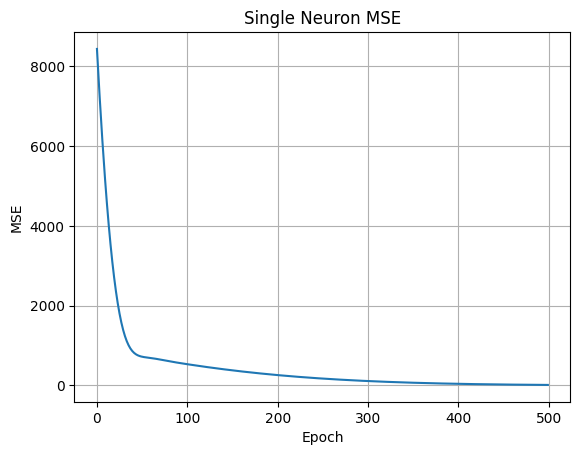

Learned rule: y = 1.8279 * x + 28.3414


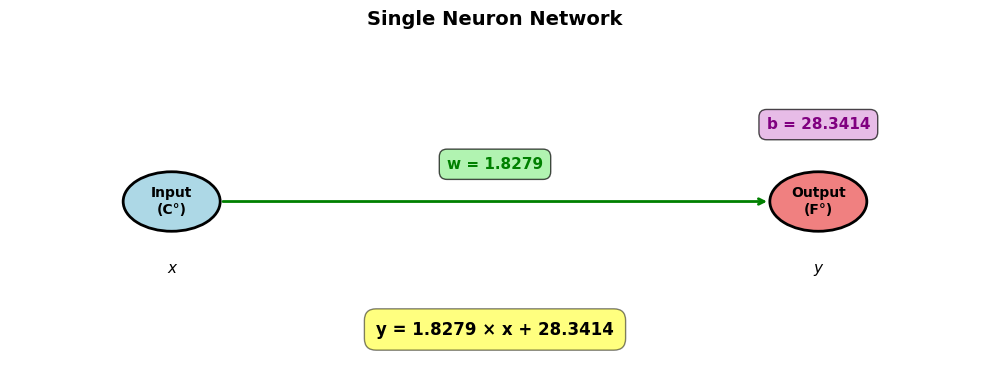

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
100°C prediction: 211.13214
Absolute error: 0.8678589


In [6]:

def train_single_neuron(x, y, epochs=500):
    model = keras.Sequential([keras.layers.Dense(1, input_shape=[1])])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.1),
        loss='mse'
    )
    history = model.fit(x, y, epochs=epochs, verbose=0)
    return model, history

single_model, single_history = train_single_neuron(celsius_q, fahrenheit_a)
plot_error(single_history, 'Single Neuron MSE')

w, b = single_model.get_weights()
w = w[0][0]; b = b[0]
print(f'Learned rule: y = {w:.4f} * x + {b:.4f}')
draw_single_neuron(w, b)

#pred = single_model.predict([100])[0][0]
pred = single_model.predict(np.array([[100]]))[0][0]
print('100°C prediction:', pred)
print('Absolute error:', abs(pred - 212))



## Task B: Multi-Neuron Rule Discovery


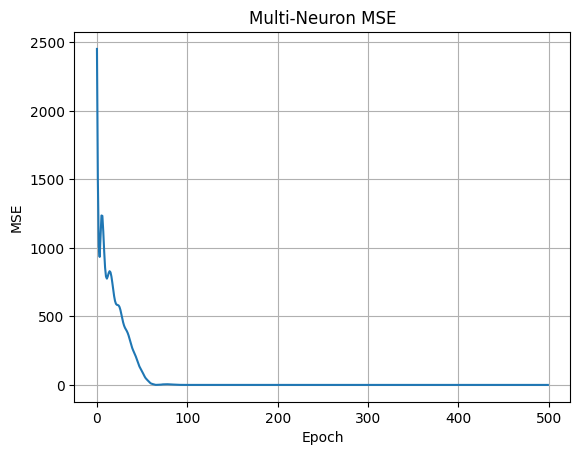

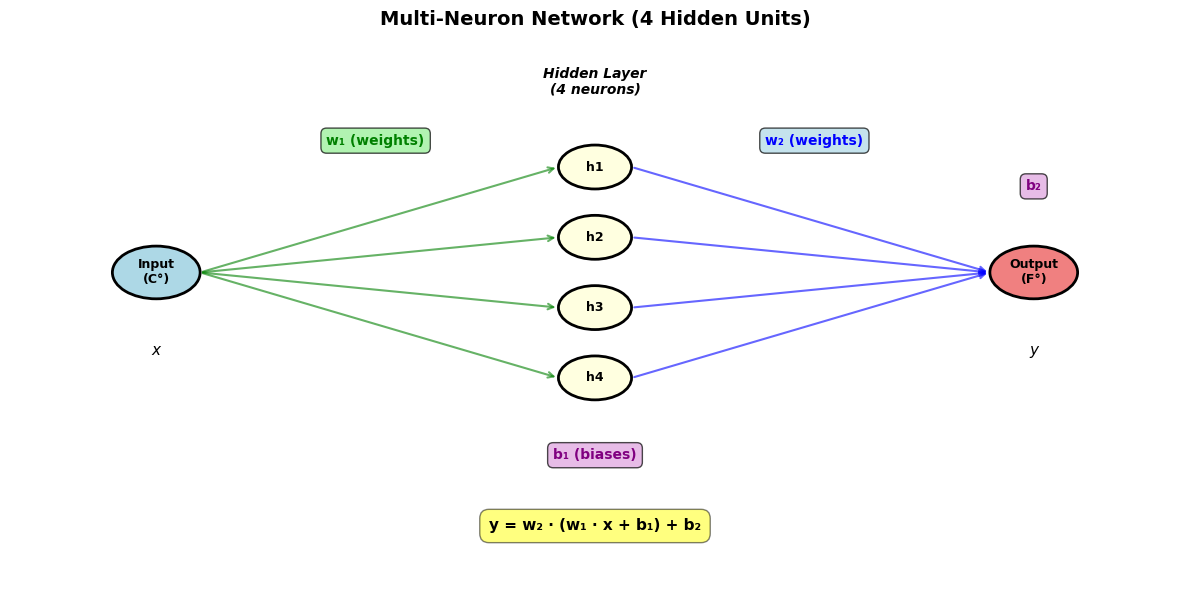

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
100°C prediction: 211.60556
Absolute error: 0.3944397


In [7]:

def train_multi_neuron(x, y, epochs=500):
    model = keras.Sequential([
        keras.layers.Dense(4, input_shape=[1]),
        keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.1),
        loss='mse'
    )
    history = model.fit(x, y, epochs=epochs, verbose=0)
    return model, history

multi_model, multi_history = train_multi_neuron(celsius_q, fahrenheit_a)
plot_error(multi_history, 'Multi-Neuron MSE')
draw_multi_neuron()

pred_multi = multi_model.predict(np.array([[100]]))[0][0]
print('100°C prediction:', pred_multi)
print('Absolute error:', abs(pred_multi - 212))



## Conclusion

- A **single neuron** is sufficient to discover the rule.
- A **multi-neuron network** converges to the same solution.
- Backpropagation without activation functions can discover mathematical rules.
- In **multi-neuron network** the MSE going down more rapidly that in **single neuron** and final absolute error is slightly smaller.
